In [1]:
from datasets import load_dataset
from transformers import BertModel, BertConfig, BertForSequenceClassification, BertTokenizer
import torch
import torch.nn as nn
import pandas as pd
from tqdm import tqdm
import os

import torch.optim as optim

import matplotlib.pyplot as plt

/home/aix7101/anaconda3/envs/j_knnee/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# parameters

#-- setting custom model
total_l = 6
trans_l = 1
base_model = "bert-base-uncased"
model_name = "textattack/bert-base-uncased-CoLA"
 
#-- setting result name
result_name = "cola_6_1"
model_save_path = f"/mnt/aix7101/jeong/ee/{result_name}.pt"

#-- setting training
train_strategy = "low_lr"  # 'freeze', 'low_lr', 'unfreeze'
num_epoch = 10
num_unfreeze = 3 

In [3]:
db = load_dataset("glue", "cola")

In [4]:
print(db)

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 8551
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1043
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1063
    })
})


In [5]:
# load train dataset
train_dataset = load_dataset("glue", "cola", split="train")

# load validation dataset
val_dataset = load_dataset("glue", "cola", split="validation")

In [6]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
dropout = nn.Dropout(p=0.1).to(device) # in BERT default 0.1

In [7]:
# setting
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, output_hidden_states=True).eval().to(device)
model.eval()

/home/aix7101/anaconda3/envs/j_knnee/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Custom model

In [8]:
from transformers import BertModel, BertConfig, BertForSequenceClassification
import torch.nn as nn
import torch

class CustomBertSmall(nn.Module):
    def __init__(self, teacher_model, total_layers=6, transplanted_layers=3):
        super().__init__()
        assert transplanted_layers < total_layers, "Transplanted layers must be fewer than total layers"
        
        self.hidden_size = teacher_model.config.hidden_size
        self.total_layers = total_layers
        self.transplanted_layers = transplanted_layers

        # 그대로 복사할 레이어 인덱스 계산
        transplanted_start = 12 - transplanted_layers
        original_layer_indices = list(range(transplanted_start))[:total_layers - transplanted_layers]

        # Embedding 복사
        self.embeddings = teacher_model.bert.embeddings

        # 선택된 layer만 복사해서 재구성
        self.encoder_layers = nn.ModuleList()

        for idx in original_layer_indices:
            layer = teacher_model.bert.encoder.layer[idx]
            self.encoder_layers.append(layer)

        for idx in range(transplanted_start, 12):
            layer = teacher_model.bert.encoder.layer[idx]
            self.encoder_layers.append(layer)

        # Pooler와 Classifier도 복사
        self.pooler = teacher_model.bert.pooler
        self.dropout = teacher_model.dropout  # from classifier head
        self.classifier = teacher_model.classifier

        self.activation = nn.Tanh()  # 여전히 pooler 내부에서도 사용되지만 보존

    # CustomBertSmall에 hidden_states 옵션 추가
    def forward(self, input_ids, attention_mask=None, token_type_ids=None, output_hidden_states=False):
        hidden_states = self.embeddings(input_ids=input_ids, token_type_ids=token_type_ids)

        if attention_mask is not None:
            extended_attention_mask = attention_mask[:, None, None, :]
            extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0
        else:
            extended_attention_mask = None

        all_hidden = []  # 각 레이어 출력 저장
        for layer in self.encoder_layers:
            hidden_states = layer(hidden_states, attention_mask=extended_attention_mask)[0]
            if output_hidden_states:
                all_hidden.append(hidden_states)

        pooled_output = self.pooler(hidden_states)
        pooled_output = self.dropout(self.activation(pooled_output))
        logits = self.classifier(pooled_output)

        if output_hidden_states:
            return logits, all_hidden
        else:
            return logits

In [9]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# model_name = "textattack/bert-base-uncased-ag-news"

teacher_model = BertForSequenceClassification.from_pretrained(base_model, num_labels=2)

small_model = CustomBertSmall(
    teacher_model=teacher_model,
    total_layers=total_l,
    transplanted_layers=trans_l,  # 마지막 l개 레이어 복사
).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## [check] before training

In [10]:
import evaluate

mcc_metric = evaluate.load("matthews_correlation")
all_preds_base, all_preds_small, all_labels = [], [], []

model.eval()
small_model.eval()

for item in tqdm(val_dataset, desc="Evaluating Small Model (CoLA)"):
    text = item["sentence"]
    label = item["label"]
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)

    with torch.no_grad():
        logits_base = model(**inputs).logits
        logits_small = small_model(**inputs)

    pred_base = torch.argmax(logits_base, dim=-1).item()
    pred_small = torch.argmax(logits_small, dim=-1).item()

    all_preds_base.append(pred_base)
    all_preds_small.append(pred_small)
    all_labels.append(label)

# MCC 계산
mcc_base = mcc_metric.compute(predictions=all_preds_base, references=all_labels)["matthews_correlation"]
mcc_small = mcc_metric.compute(predictions=all_preds_small, references=all_labels)["matthews_correlation"]

print(f"\n✅ MCC of BERT-base: {mcc_base:.4f}")
print(f"✅ MCC of CustomBertSmall: {mcc_small:.4f}")

Evaluating Small Model (CoLA): 100%|██████████| 1043/1043 [00:16<00:00, 61.75it/s]



✅ MCC of BERT-base: 0.5339
✅ MCC of CustomBertSmall: 0.0000


## Custom Loss

In [11]:
import torch.nn.functional as F
from torch.nn import MSELoss, KLDivLoss

def loss1(logits, labels):
    return F.cross_entropy(logits, labels)

# Representation Matching Loss (MSE between CLS tokens)
def loss2(student_hidden, teacher_hidden):
    mse = MSELoss()
    return mse(student_hidden, teacher_hidden)

# DSR Loss (KL Divergence between sorted logits)
def loss3(prev_logits, current_logits, tau=1.0):
    z_prev = torch.sort(prev_logits, dim=-1)[0]
    z_current = torch.sort(current_logits, dim=-1)[0]

    p_prev = F.softmax(z_prev / tau, dim=-1)
    p_current = F.log_softmax(z_current / tau, dim=-1)

    kldiv = KLDivLoss(reduction='batchmean')
    return (tau ** 2 / 2) * kldiv(p_current, p_prev)  # KL(p_prev || p_current)

In [12]:
import torch
import torch.nn.functional as F

def compute_cka(X: torch.Tensor, Y: torch.Tensor, eps=1e-8):
    X = X - X.mean(dim=0, keepdim=True)
    Y = Y - Y.mean(dim=0, keepdim=True)

    dot_product_similarity = (X.T @ Y).norm(p='fro') ** 2
    normalization_x = (X.T @ X).norm(p='fro')
    normalization_y = (Y.T @ Y).norm(p='fro')
    return dot_product_similarity / (normalization_x * normalization_y + eps)

def cka_delta_loss(h_teacher_bef, h_teacher_aft, h_student_bef, h_student_aft):
    delta_t = h_teacher_aft - h_teacher_bef
    delta_s = h_student_aft - h_student_bef
    t = delta_t[:, 0, :]  # CLS
    s = delta_s[:, 0, :]
    return 1 - compute_cka(t, s)

## Train

In [13]:
import evaluate as ev

def evaluate(model, val_loader, tokenizer, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating"):
            text = batch["sentence"][0]
            label = batch["label"].item()

            inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)
            logits = model(**inputs)
            pred = torch.argmax(logits, dim=-1).item()

            all_preds.append(pred)
            all_labels.append(label)

    # MCC metric 계산
    mcc = ev.load("matthews_correlation")
    result = mcc.compute(predictions=all_preds, references=all_labels)

    return result["matthews_correlation"] * 100  # 퍼센트로 표현

In [14]:
import torch
from transformers import BertForSequenceClassification, AutoTokenizer
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import AdamW

def train_custom_model(
    model,
    train_dataset,
    val_dataset,
    tokenizer,
    teacher_model=None,  # 👈 custom loss를 쓸 경우 필요
    custom_loss=False,   # 👈 Loss type 선택
    strategy="freeze",
    batch_size=16,
    epochs=10,
    base_lr=5e-5,
    low_lr=5e-6,
    k=3,
    alpha=0.3,           # 👈 custom loss 비중
    unfreeze_epoch=1,
    save_path="best_model.pt",
    device="cuda" if torch.cuda.is_available() else "cpu"
):
    model = model.to(device)
    # if torch.cuda.device_count() > 1:
    #     print(f"🔧 Using {torch.cuda.device_count()} GPUs with DataParallel")
    #     model = nn.DataParallel(model)
    if custom_loss and teacher_model is None:
        raise ValueError("teacher_model must be provided when using custom_loss=True")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1)

    if strategy == "low_lr":
        optimizer_grouped = [
            {"params": [p for l in model.encoder_layers[:-k] for p in l.parameters()], "lr": base_lr},
            {"params": [p for l in model.encoder_layers[-k:] for p in l.parameters()], "lr": low_lr},
            {"params": model.pooler.parameters(), "lr": base_lr},
            {"params": model.classifier.parameters(), "lr": base_lr},
        ]
    else:
        optimizer_grouped = model.parameters()

    optimizer = AdamW(optimizer_grouped, lr=base_lr)
    loss_fn = nn.CrossEntropyLoss()

    if strategy == "freeze":
        for layer in model.encoder_layers[-k:]:
            for param in layer.parameters():
                param.requires_grad = False
        ##-- freeze first layer
        # for param in model.encoder_layers[0].parameters():
        #     param.requires_grad = False

    best_acc = 0.0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        print(f"\nEpoch {epoch+1}/{epochs}")

        if strategy == "unfreeze" and epoch == unfreeze_epoch:
            print("--<Unfreezing last K layers>--")
            for layer in model.encoder_layers[-k:]:
                for param in layer.parameters():
                    param.requires_grad = True

        for batch in tqdm(train_loader, desc="Training"):
            texts = batch["sentence"]
            labels = batch["label"]

            tokenized = tokenizer(list(texts), return_tensors="pt", padding=True, truncation=True)
            inputs = {k: v.to(device) for k, v in tokenized.items()}
            labels = labels.to(device)

            optimizer.zero_grad()

            if custom_loss:
                # ----> Custom Loss: CE + CKA delta loss
                logits_small, student_hiddens = model(**inputs, output_hidden_states=True)
                ce_loss = loss_fn(logits_small, labels)

                with torch.no_grad():
                    teacher_outputs = teacher_model(**inputs, output_hidden_states=True)
                    h_teacher_bef = teacher_outputs.hidden_states[(-1)-(k+1)]
                    h_teacher_aft = teacher_outputs.hidden_states[(-1)-k]

                h_student_bef = student_hiddens[(-1)-(k+1)]
                h_student_aft = student_hiddens[(-1)-k]

                cka_loss = cka_delta_loss(h_teacher_bef, h_teacher_aft, h_student_bef, h_student_aft)
                loss = ce_loss + alpha * cka_loss
            else:
                # ----> 기본 CE Loss만 사용
                logits = model(**inputs)
                loss = loss_fn(logits, labels)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Avg Training Loss: {avg_loss:.4f}")

        acc = evaluate(model, val_loader, tokenizer, device)
        print(f"Validation MCC: {acc:.2f}%")

        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), save_path)
            print(f"✅ New best model saved with accuracy: {best_acc:.2f}% → {save_path}")

In [15]:
train_custom_model(
    model=small_model,
    teacher_model=model,   # 꼭 전달!
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    tokenizer=tokenizer,
    custom_loss=True,              # ✅ 사용
    alpha=0.3,                     # CKA 가중치
    k=trans_l,
    strategy="train_strategy",
    unfreeze_epoch=num_unfreeze,
    epochs=num_epoch,
    save_path=model_save_path,
    device=device
)


Epoch 1/10


Training: 100%|██████████| 535/535 [00:24<00:00, 21.73it/s]


Avg Training Loss: 0.7122


Evaluating: 100%|██████████| 1043/1043 [00:07<00:00, 136.58it/s]


Validation MCC: 23.54%
✅ New best model saved with accuracy: 23.54% → /mnt/aix7101/jeong/ee/cola_6_1.pt

Epoch 2/10


Training: 100%|██████████| 535/535 [00:23<00:00, 22.64it/s]


Avg Training Loss: 0.5319


Evaluating: 100%|██████████| 1043/1043 [00:04<00:00, 212.75it/s]


Validation MCC: 30.76%
✅ New best model saved with accuracy: 30.76% → /mnt/aix7101/jeong/ee/cola_6_1.pt

Epoch 3/10


Training: 100%|██████████| 535/535 [00:19<00:00, 28.07it/s]


Avg Training Loss: 0.3391


Evaluating: 100%|██████████| 1043/1043 [00:07<00:00, 136.61it/s]


Validation MCC: 29.54%

Epoch 4/10


Training: 100%|██████████| 535/535 [00:23<00:00, 22.71it/s]


Avg Training Loss: 0.2210


Evaluating: 100%|██████████| 1043/1043 [00:07<00:00, 136.01it/s]


Validation MCC: 36.83%
✅ New best model saved with accuracy: 36.83% → /mnt/aix7101/jeong/ee/cola_6_1.pt

Epoch 5/10


Training: 100%|██████████| 535/535 [00:23<00:00, 22.72it/s]


Avg Training Loss: 0.1574


Evaluating: 100%|██████████| 1043/1043 [00:07<00:00, 137.16it/s]


Validation MCC: 37.83%
✅ New best model saved with accuracy: 37.83% → /mnt/aix7101/jeong/ee/cola_6_1.pt

Epoch 6/10


Training: 100%|██████████| 535/535 [00:23<00:00, 22.68it/s]


Avg Training Loss: 0.1245


Evaluating: 100%|██████████| 1043/1043 [00:07<00:00, 136.78it/s]


Validation MCC: 34.30%

Epoch 7/10


Training: 100%|██████████| 535/535 [00:23<00:00, 22.90it/s]


Avg Training Loss: 0.1127


Evaluating: 100%|██████████| 1043/1043 [00:07<00:00, 139.40it/s]


Validation MCC: 33.42%

Epoch 8/10


Training: 100%|██████████| 535/535 [00:19<00:00, 26.84it/s]


Avg Training Loss: 0.0947


Evaluating: 100%|██████████| 1043/1043 [00:03<00:00, 262.61it/s]


Validation MCC: 34.90%

Epoch 9/10


Training: 100%|██████████| 535/535 [00:17<00:00, 29.87it/s]


Avg Training Loss: 0.0852


Evaluating: 100%|██████████| 1043/1043 [00:03<00:00, 261.30it/s]


Validation MCC: 36.20%

Epoch 10/10


Training: 100%|██████████| 535/535 [00:17<00:00, 29.97it/s]


Avg Training Loss: 0.0856


Evaluating: 100%|██████████| 1043/1043 [00:03<00:00, 262.15it/s]


Validation MCC: 35.80%


## [check] after training

In [16]:
# load model

small_model.load_state_dict(torch.load(model_save_path, map_location=device))
small_model = small_model.eval().to(device)


In [17]:
import evaluate

mcc_metric = evaluate.load("matthews_correlation")
all_preds_base, all_preds_small, all_labels = [], [], []

model.eval()
small_model.eval()

for item in tqdm(val_dataset, desc="Evaluating Small Model (CoLA)"):
    text = item["sentence"]
    label = item["label"]
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)

    with torch.no_grad():
        logits_base = model(**inputs).logits
        logits_small = small_model(**inputs)

    pred_base = torch.argmax(logits_base, dim=-1).item()
    pred_small = torch.argmax(logits_small, dim=-1).item()

    all_preds_base.append(pred_base)
    all_preds_small.append(pred_small)
    all_labels.append(label)

# MCC 계산
mcc_base = mcc_metric.compute(predictions=all_preds_base, references=all_labels)["matthews_correlation"]
mcc_small = mcc_metric.compute(predictions=all_preds_small, references=all_labels)["matthews_correlation"]

print(f"\n✅ MCC of BERT-base: {mcc_base:.4f}")
print(f"✅ MCC of CustomBertSmall: {mcc_small:.4f}")

Evaluating Small Model (CoLA): 100%|██████████| 1043/1043 [00:10<00:00, 99.28it/s]


✅ MCC of BERT-base: 0.5339
✅ MCC of CustomBertSmall: 0.3783


In [18]:
import evaluate

# MCC metric 로드
mcc_metric = evaluate.load("matthews_correlation")

# MCC 저장 리스트
mcc_original = []
mcc_small = [0] * total_l  # small_model의 레이어 수만큼 MCC 저장

for layer in range(1, 13):  # BERT-base: layer 1~12
    preds_orig = []
    labels = []

    preds_small_by_layer = [[] for _ in range(total_l)]

    for item in tqdm(val_dataset, desc=f"Layer {layer}"):
        text = item["sentence"]
        label = item["label"]
        labels.append(label)

        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)

        with torch.no_grad():
            # BERT-base layer별 hidden state 사용
            outputs = model(**inputs, output_hidden_states=True)
            hidden = outputs.hidden_states[layer]
            pooled = model.bert.pooler(hidden)
            pooled_dropped = dropout(pooled)
            logits_orig = model.classifier(pooled_dropped)
            pred_orig = torch.argmax(logits_orig, dim=-1).item()
            preds_orig.append(pred_orig)

            # small model 모든 hidden state에서 MCC 평가
            logits_small, small_hidden_states = small_model(**inputs, output_hidden_states=True)
            for i, h in enumerate(small_hidden_states):
                pooled_small = small_model.pooler(h)
                pooled_small = dropout(pooled_small)
                logits = small_model.classifier(pooled_small)
                pred = torch.argmax(logits, dim=-1).item()
                preds_small_by_layer[i].append(pred)

    # MCC 계산
    mcc_o = mcc_metric.compute(predictions=preds_orig, references=labels)["matthews_correlation"]
    mcc_original.append(mcc_o)

    if layer == 12:
        for i in range(total_l):
            mcc_i = mcc_metric.compute(predictions=preds_small_by_layer[i], references=labels)["matthews_correlation"]
            mcc_small[i] = mcc_i

Layer 12: 100%|██████████| 1043/1043 [00:11<00:00, 92.17it/s]


In [19]:
mcc_original

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.19409321068227886,
 0.4566824750149941,
 0.5311686988596115]

In [20]:
mcc_small

[0.0, 0.0, 0.0, 0.0, 0.34774097745904614, 0.37609038457898425]

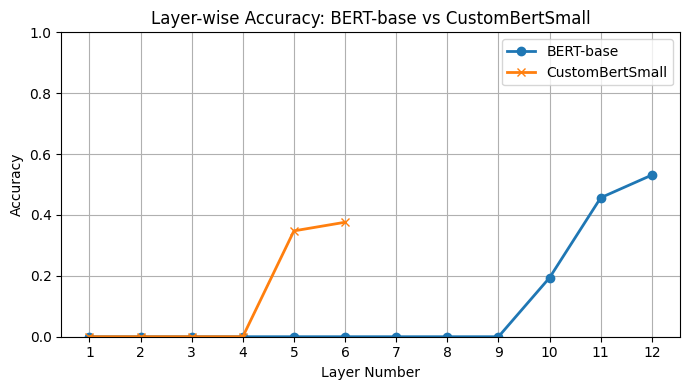

In [21]:
plt.figure(figsize=(7, 4))
plt.plot(range(1, 13), mcc_original, label="BERT-base", marker='o', linewidth=2)
plt.plot(range(1, total_l + 1), mcc_small, label="CustomBertSmall", marker='x', linewidth=2)
plt.xlabel("Layer Number")
plt.ylabel("Accuracy")
plt.title("Layer-wise Accuracy: BERT-base vs CustomBertSmall")
plt.legend()
plt.grid(True)
plt.xticks(range(1, 13))
plt.ylim(0, 1.0)
plt.tight_layout()
plt.savefig(f"/home/aix7101/jeong/ee/ours/codes/img/{result_name}.png", dpi=300)
plt.show()